# Exploring a canopy RT model: PROSAIL
## J Gómez-Dans (UCL & NCEO)


### This implementation of PROSAIL

There are quite a few different versions of the SAIL model. This is probably the second simplest, as it assumes a single canopy layer, with a simple hotspot correction. The soil boundary is assumed to be Lambertian, and a combination of two soil spectra (typically one wet and one dry). Leaf optical properties are calculated with **PROSPECT 5B** (which you should already be familiar with). In total, we have 11 input parameters (as well as the illumination/acquisition geometry, controlled by the solar zenith angle, the view zenith angle and the relative azimuth angle). The input parameters are

* $N$ (leaf layers)
* $Cab$ (chlorophyll ab conc)
* $Car$ (carotenoid conc)
* $Cbrown$ (senescent pigment
* $Cw$ (equivalent leaf water)
* $Cm$ (dry matter conc)
* LAI (leaf area index)
* LIDF (the mean leaf angle)
* RSOIL (soil spectrum 1)
* PSOIL (soil spectrum 2)
* HOTSPOT (the value of the hotspot parameter, typically the ratio of leave size to canopy height)

This version of PROSAIL uses a Campbell leaf angle distribution function. Rather than choosing discrete distributions, the Campbell function parameterises the LAD function with a single parameter, the mean leaf angle.

### Sensitivity analysis

The aim of this exercise is to look at the sensitivity of PROSAIL to different parametes spectrally, in a way that is similar to what you did before with PROSPECT. Remember that this experiment is still a local sensitivity analysis experiment around $\mathbf{x_0}$, so make sure you consider different locations in parameter space. Also consider the effect of acquisition geometry.

You can use the function **``prosail_sensitivity_ssa``**, from ``prosail_functions``. Remember that this function has extensive help on its syntax.

* Where do parameters show the most/the least sensitivity spectrally?
* Where do these sensitivities change with acquisition geometry?



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prosail_functions import *
plot_config()
import prosail

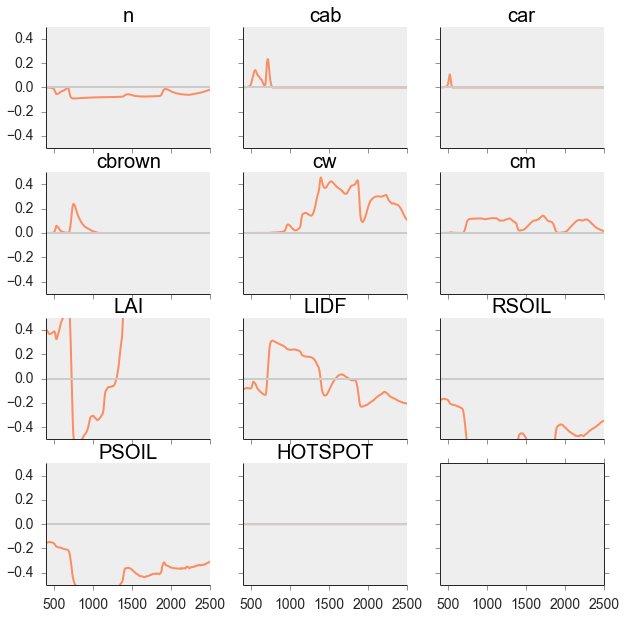

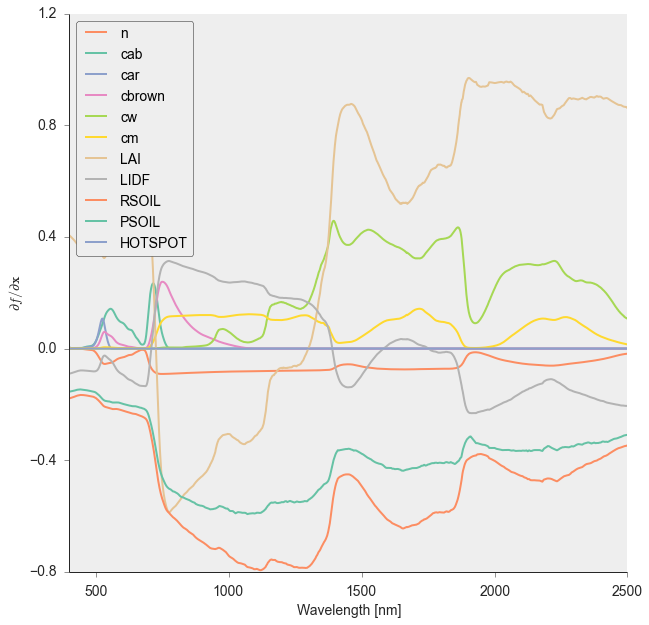

In [2]:
w,s = prosail_sensitivity_ssa(vza=0, sza=0)


### Exploring the MTCI (MERIS Terrestrial Chlorophyll Index)

The MTCI is a vegetation index that was developed for data from the MERIS sensor onboard the ENVISAT platform, and that relates surface reflectance to canopy chlorophyll content. The index is defined as the ratio of reflectance differences between MERIS bands 10 and 9 to reflectance differences between bands 9 and 8. 

$$
MTCI = \frac{R_{753}-R_{705}}{R_{705}-R_{681}},
$$
where $R_{x}$ indicated reflectance for a waveband whose centre wavelength is located at $x$. In this experiment, we will use PROSAIL to look at the robustness of such an index. We note that the bandwidth of these three bands is 7.5, 10 and 7.5 $nm$.

* A first experiment will be to determine the strength of the relationship just sweeping over the chlorophyll concentration while keeping all other parameters fixed. Find the best relationship
* As a second experiment



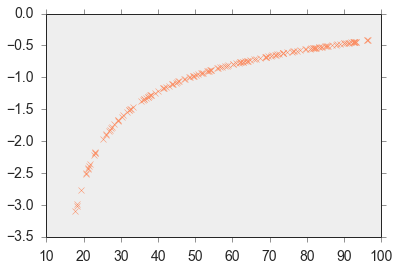

In [29]:
def mtci_experiment ( x0=np.array([1.5, 40., 5., 0., 0.0113, 0.0053, 1, 
                                           30., 0, 0, 0.01]), 
                    minvals = {'n':1.0, 'cab':15., 'car':10., 'cbrown': 0., 'cw':0.001, 'cm':0.0, 
                               'lai':.5, 'lidf':0., 'rsoil':0., 'psoil':0., 'hspot':0.0001 },
                    maxvals = { 'n': 2.5, 'cab': 80., 'car':20., 'cbrown': .4, 'cw':0.04, 'cm': 0.5,
                               'lai':4.05, 'lidf':90., 'rsoil':2., 'psoil':2., 'hspot':0.5 },
                     nuisance=None, sza=0., vza=30., raa=0. ):
    param_position = ['n','cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'lidf', 'rsoil', 'psoil' ]
    wv = np.arange( 400, 2501 )
    band8_pass = np.logical_and ( wv >= 681 - 4, wv >= 681 + 4)
    band9_pass = np.logical_and ( wv >= 709 - 5, wv >= 709 + 5)
    band10_pass = np.logical_and ( wv >= 754 - 4, wv >= 754 + 4)
    MTCI = []
    xp = x0*1.
    cab_axis = []
    for n_tries in xrange(10):
        for cab in np.arange(20, 100, 5):
            cab = cab + 5.*(np.random.rand() - 0.5 )
            if nuisance is None: # No flipping parameters around
                xp[1] = cab
                r = call_prosail ( *(xp.tolist() + [sza, vza,raa]) )
                r8 = r[band8_pass].mean()
                r9 = r[band9_pass].mean()
                r10 = r[band10_pass].mean()
                mtci = ( r10-r9)/(r9-r8)
                MTCI.append ( mtci )
                cab_axis.append ( cab )
            else:
                for nuisance_parameter in nuisance:
                    delta = maxvals[nuisance_parameter] - minvals[nuisance_parameter]
                    ip = param_position.index ( nuisance_parameter )
                    
                    s = minvals[nuisance_parameter] +  np.random.rand()  * delta
                    xp[ip] =  s
                
                xp[1] = cab
                r = call_prosail ( *(xp.tolist() + [sza, vza,raa]) )
                r8 = r[band8_pass].mean()
                r9 = r[band9_pass].mean()
                r10 = r[band10_pass].mean()
                mtci = ( r10-r9)/(r9-r8)
                MTCI.append ( mtci )
                cab_axis.append ( cab )
        
            
            
    return cab_axis, np.array( MTCI )
x, y = mtci_experiment( )
plt.plot( x, y, 'x')

